## Importing Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('data_preprocessed.csv')
df = df.dropna()

In [4]:
df

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0,40,USA,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0,13,USA,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0,40,USA,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0,40,USA,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0,40,other,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,33,Private,245211,Bachelors,Never-married,Prof-specialty,Own-child,White,Male,0.0,0,40,USA,<=50K
48837,39,Private,215419,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,0.0,0,36,USA,<=50K
48839,38,Private,374983,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,0.0,0,50,USA,<=50K
48840,44,Private,83891,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455.0,0,40,USA,<=50K


In [8]:
X = df.drop('income', axis=1)
y = df['income'].apply(lambda x: 1 if x=='>50K' else 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


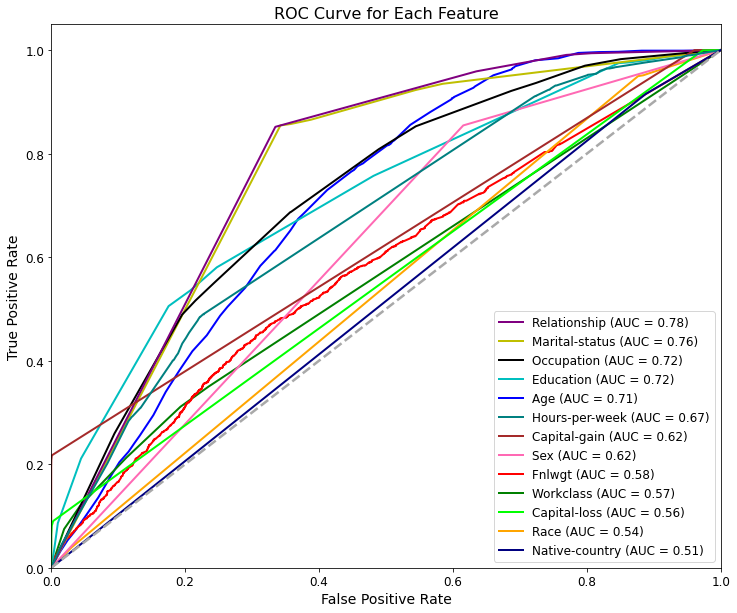

In [10]:
features = ['age', 'workclass', 'fnlwgt', 'education',
            'marital-status', 'occupation', 'relationship', 'race',
            'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

plt.figure(figsize=(12, 10))

colors = {
    'age': 'b',
    'workclass': 'g',
    'fnlwgt': 'r',
    'education': 'c',
    'education-num': 'm',
    'marital-status': 'y',
    'occupation': 'k',
    'relationship': 'purple',
    'race': 'orange',
    'sex': 'hotpink',
    'capital-gain': 'brown',
    'capital-loss': 'lime',
    'hours-per-week': 'teal',
    'native-country': 'navy'
}

auc_values = []

for feature in features:
    
    if feature in ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']:
        X_temp = X_train[[feature]]
    else:
        X_temp = pd.get_dummies(X_train[[feature]], drop_first=True)
    
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_train, test_size=0.2, random_state=43, stratify=y_train)
    clf = RandomForestClassifier()
    clf.fit(X_train_temp, y_train_temp)
    y_prob = clf.predict_proba(X_test_temp)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test_temp, y_prob)
    roc_auc = auc(fpr, tpr)
    auc_values.append((feature, roc_auc))

    
    plt.plot(fpr, tpr, lw=2, linestyle='-', color=colors[feature], label=f'{feature.capitalize()} (AUC = {roc_auc:.2f})')


auc_values.sort(key=lambda x: x[1], reverse=True) # Sortujemy legendę malejąco względem wartości AUC


handles, labels = plt.gca().get_legend_handles_labels()
order = [labels.index(f'{feat.capitalize()} (AUC = {auc:.2f})') for feat, auc in auc_values]
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order], loc="lower right", fontsize=12)


plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve for Each Feature', fontsize=16)


plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.plot([0, 1], [0, 1], color='darkgray', linestyle='--',linewidth = 2.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.show()

In [11]:
import pandas as pd
import numpy as np

def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>12):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
            
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = (d['Events']+ 0.001) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = (d['Non-Events']+0.001) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

df_code = X_train
df_code['income'] = y_train
iv, woe = iv_woe(data = df_code, target = 'income', bins=10, show_woe = True)
iv_sorted=iv.sort_values(by='IV', ascending=True)

print(iv)

Information value of age is 1.007203
  Variable          Cutoff     N  Events  % of Events  Non-Events  \
0      age  (16.999, 22.0]  3941      19     0.002079        3922   
1      age    (22.0, 26.0]  3776     173     0.018932        3603   
2      age    (26.0, 30.0]  3852     595     0.065113        3257   
3      age    (30.0, 34.0]  4056     959     0.104946        3097   
4      age    (34.0, 37.0]  3148     945     0.103414        2203   
5      age    (37.0, 41.0]  3840    1306     0.142920        2534   
6      age    (41.0, 45.0]  3486    1304     0.142701        2182   
7      age    (45.0, 50.0]  3667    1467     0.160539        2200   
8      age    (50.0, 57.0]  3601    1376     0.150580        2225   
9      age    (57.0, 90.0]  3459     994     0.108777        2465   

   % of Non-Events       WoE        IV  
0         0.141650  4.221308  0.589170  
1         0.130129  1.927667  0.214350  
2         0.117632  0.591441  0.031062  
3         0.111854  0.063740  0.000440 

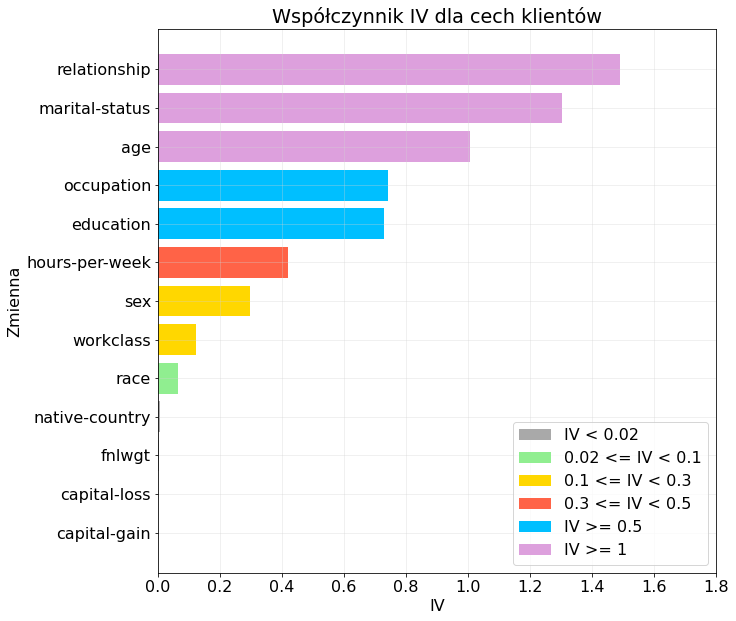

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Posortuj wartości IV od najdłuższego
iv_sorted_descending = iv_sorted.sort_values(by='IV', ascending=True)
plt.rcParams.update({'font.size': 16})
# Ustal kolor dla słupków na podstawie wartości IV
colors = []
labels = [] 
for iv in iv_sorted_descending['IV']:
    if iv < 0.02:
        colors.append('darkgrey')
    elif 0.02 <= iv < 0.1:
        colors.append('lightgreen')
    elif 0.1 <= iv < 0.3:
        colors.append('gold')
    elif 0.3<=iv<0.5:
        colors.append('tomato')
    elif 0.5<=iv<1:
        colors.append('deepskyblue')
    else:
        colors.append('plum')

# Utwórz wykres słupkowy poziomy dla wartości IV z odpowiednimi kolorami
plt.figure(figsize=(10, 10))
bars = plt.barh(iv_sorted_descending['Variable'], iv_sorted_descending['IV'], color=colors)
plt.xlabel('IV')
plt.ylabel('Zmienna')
plt.title('Współczynnik IV dla cech klientów')
plt.xlim(0,1.8)

import matplotlib.pyplot as plt

# ... Twój kod wykresu ...

# Ręcznie definiujemy legendę dla każdego koloru
legend_labels = {
    'darkgrey': 'IV < 0.02',
    'lightgreen': '0.02 <= IV < 0.1',
    'gold': '0.1 <= IV < 0.3',
    'tomato': '0.3 <= IV < 0.5',
    'deepskyblue': 'IV >= 0.5',
    'plum': 'IV >= 1'
}

# Dodajemy legendę ręcznie dla każdego koloru
for color, label in legend_labels.items():
    plt.bar(0, 0, color=color, label=label)

# Dodajemy legendę główną (prawdziwą) w celu ukrycia "pustych" słupków w prawym górnym rogu
plt.legend(loc='lower right')
plt.grid(True, color='lightgrey',alpha=0.4)
#plt.savefig('do prezentacji wykresy/IV.png',bbox_inches='tight',dpi=300)


plt.show()